In [ ]:
from argparse import Namespace
from glob import glob
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torchvision.transforms as transforms
import torchvision
import albumentations as A

args = Namespace(
    janus_model_path = 'deepseek-ai/Janus-Pro-1B',
    model_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/outputs',
    pretrained_model_path = 'stabilityai/stable-diffusion-2-depth',
    image_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Input',
    single_image_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Input/input_7.png',
    variant_folder = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Inference/5-variant_folder',
    augment1 = A.Compose([
        A.OneOf([
            A.HorizontalFlip(p=0.9),  # Flip horizontally
            A.VerticalFlip(p=0.9)], p=0.7)
    ]),    # Flip vertically
    augment2 = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.5, p=0.8),  # Adjust brightness and contrast
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.7),  # Apply Contrast Limited Adaptive Histogram Equalization
        A.Equalize(p=0.6),  # Apply histogram equalization
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4), # Randomly change brightness, contrast, and saturation
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.7),]),      # Adjust hue and saturation
    output_alphabet = ['a', 'b', 'c', 'd', 'e'],
    seed = [42, 123, 456, 789, 101112],
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    prompt_for_understanding_image = 'Analyze the depth information of the image and describe its structural details, focusing on object positioning, foreground and background separation, and intricate textures. Emphasize the key depth-based elements that define the scene and generate a detailed textual description suitable for guiding image variation synthesis. Answer in 2 sentences',
    answer = [],
    negative_prompt = "bad, deformed, ugly, bad anotomy, bad resolution, bad quality, bad asthetic, blurry",
    num_variations = 5,
    upscale_width = [],
    upscale_height = [],
    augmented_folder = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Inference/5-variant_folder/augmented',
    generated_folder = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Inference/5-variant_folder/generated',
    augmented_folder_list = [],
    generated_folder_list = [],
)

In [2]:
for i in range(args.num_variations):
    # Load the image
    init_image = Image.open(args.single_image_path).convert("RGB")
    init_image_np = np.array(init_image)
    
    # Get the original image dimensions
    width, height = init_image.size
    args.upscale_width.append(width // 2)
    args.upscale_height.append(height // 2)
    
    # Compute new dimensions
    new_width, new_height = width // 2, height // 2

    # Alternate between the two augmentation methods
    if i % 2 == 0:
        # First method (Augmentation 1 + Augmentation 2 + RandomCrop)
        # Apply the first augmentation (flip transformations)
        augmented_image = args.augment1(image=init_image_np)
        init_image = Image.fromarray(augmented_image['image'])

        # Apply the second set of augmentations (brightness, contrast, color)
        augmented_image = args.augment2(image=np.array(init_image))
        init_image = Image.fromarray(augmented_image['image'])
        
        # Apply random crop transformation
        augmented_image = A.RandomCrop(width=args.upscale_width[i], height=args.upscale_height[i], p=1.0)
        cropped_image = augmented_image(image=np.array(init_image))['image']

        # Convert back to PIL Image
        init_image2 = Image.fromarray(cropped_image)

    else:
        # Second method (Augmentation 1 + Augmentation 2 + Resize + Crop)
        # Apply the first augmentation (flip transformations)
        augmented_image1 = args.augment1(image=init_image_np)
        init_image1 = Image.fromarray(augmented_image1['image'])

        # Apply the second set of augmentations (brightness, contrast, color)
        augmented_image2 = args.augment2(image=np.array(init_image1))
        init_image2 = Image.fromarray(augmented_image2['image'])
        
        # Apply resize transformation
        resize_transform = A.Resize(width=new_width, height=new_height, p=1.0)
        init_image2 = resize_transform(image=np.array(init_image2))['image']  # Ensure this returns a dictionary and access 'image'
        
        # Apply random crop transformation
        crop_transform = A.RandomCrop(width=args.upscale_width[i], height=args.upscale_height[i], p=1.0)
        cropped_image = crop_transform(image=np.array(init_image2))['image']  # Same here, access 'image' in the dict

        # Convert back to PIL Image
        init_image2 = Image.fromarray(cropped_image)

    # Optionally, save or display the final image
    init_image2.save(f"{args.augmented_folder}/augmented_image{i}.png")


In [3]:
import inference_utils
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from PIL import Image
import numpy as np
import os
import time
from IPython.display import display
from urllib.request import urlopen

config = AutoConfig.from_pretrained(args.janus_model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(args.janus_model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)
if args.device == 'cuda':
    vl_gpt = vl_gpt.to(torch.bfloat16).cuda()
else:
    vl_gpt = vl_gpt.to(torch.float16)

vl_chat_processor = VLChatProcessor.from_pretrained(args.janus_model_path)
tokenizer = vl_chat_processor.tokenizer


Python version is above 3.10, patching the collections module.


/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:594: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Jupyter compare_view v0.2.4


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: add_special_token, image_tag, sft_format, i

In [4]:
args.augmented_folder_list = glob(f"{args.augmented_folder}/*.png")
for i in range(args.num_variations):
    answer = inference_utils.multimodal_understanding(
        image = args.augmented_folder_list[i],
        question=args.prompt_for_understanding_image,
        seed = args.seed[i],
        top_p = 0.8,
        temperature = 1.0,
        vl_chat_processor = vl_chat_processor,
        vl_gpt = vl_gpt,
        tokenizer = tokenizer,
        cuda_device = args.device,
    )
    args.answer.append(answer)
print(args.answer)

['The image showcases a highly detailed and layered composition with intricate floral patterns, blending deep teal and pink hues against a cream background. The foreground is filled with bold, stylized floral motifs in turquoise and pink, creating a sense of depth through overlapping and intricate detailing, while the background consists of lighter cream and muted colors that provide a smooth transition, highlighting the structured interplay between foreground and background.', 'The image displays a complex scene of intricate patterns, with overlapping rectangular frames filled with swirling motifs and floral designs in a palette of dark browns, blues, and oranges. The foreground consists of a lighter, almost transparent rectangular layer with subtle texture variations, while the background comprises a gradient of neutral shades, emphasizing depth through subtle layering and contrast.', 'The image presents a composition of intricately designed rectangular and square shapes, with patter

In [5]:
inference_utils.__remove_variables_for_memory(args)   

Cleared all global variables except: args


In [6]:
torch.cuda.empty_cache()

In [7]:
import torch
import requests
from PIL import Image

from diffusers import StableDiffusionDepth2ImgPipeline
from diffusers.utils import load_image

pipe1 = StableDiffusionDepth2ImgPipeline.from_pretrained(
    args.model_path,
    torch_dtype=torch.float16,
).to(args.device)
pipe1.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['play between foreground and background .']


0.4565306470147119 7.688754356668932


  0%|          | 0/22 [00:00<?, ?it/s]

0.5981397205052419 5.501942914503951


  0%|          | 0/29 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['depth within the flat design .']


0.3383265357097537 8.199625955991472


  0%|          | 0/16 [00:00<?, ?it/s]

0.509085340340252 6.567444619344213


  0%|          | 0/25 [00:00<?, ?it/s]

0.4501816521924895 9.766342253020476


  0%|          | 0/22 [00:00<?, ?it/s]

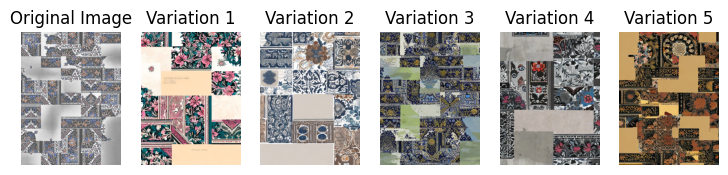

In [8]:
import inference_utils
import random

for i in range(args.num_variations):
    init_image2 = Image.open(args.augmented_folder_list[i]).convert("RGB")
    prompt = args.answer[i]
    n_prompt = "bad, deformed, ugly, bad anotomy, bad resolution, bad quality, bad asthetic, blurry"
    alphabet = args.output_alphabet[i]
    seed = args.seed[i]
    generator = torch.Generator(device=args.device).manual_seed(seed)
    # strength, guidance_scale = inference_utils.generate_values()
    strength = inference_utils.__generate_strength()
    guidance_scale = inference_utils.__generate_guidance_scale()
    print(strength, guidance_scale)
    image = pipe1(prompt=prompt, image=init_image2, negative_prompt=n_prompt, strength=strength, guidance_scale=guidance_scale, generator=generator).images[0]
    image.save(f"{args.generated_folder}/generated_image_{i}.png")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(9, 12))
ax[0].imshow(init_image)
ax[0].set_title("Original Image")
ax[0].axis("off")
for j in range(args.num_variations):
    variation_path = os.path.join(args.generated_folder, f"generated_image_{j}.png")
    variation_image = Image.open(variation_path).convert("RGB")

    ax[j+1].imshow(variation_image)
    ax[j+1].set_title(f"Variation {j+1}")
    ax[j+1].axis("off")
plt.axis("off")
plt.show()

In [9]:
import torch
from diffusers import StableDiffusionUpscalePipeline
from PIL import Image

# Load the pre-trained upscaler model from Stability AI
upscale_pipeline = StableDiffusionUpscalePipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16
).to("cuda")

# Open the image (low resolution)
image_path = "input_image.jpg"
image = Image.open(image_path).convert("RGB")

# Resize the image to half of the target resolution (if target is 2x upscaling)
width, height = image.size
image_resized = image.resize((width // 2, height // 2))

# Define your prompt
prompt = "high quality, detailed, sharp image"

# Upscale image by 2x using the Stable Diffusion model
upscaled_image = upscale_pipeline(prompt=prompt, image=image_resized, guidance_scale=7.5).images[0]

# Save and display the upscaled image
upscaled_image.save("upscaled_2x.png")
upscaled_image.show()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'input_image.jpg'